# Three Phase Motor Drive With Sigma-Delta Modulators 

This notebook introduces a low latency, low power, hardware efficient three phase motor control technology. We explore a multiplier-less sigma-delta (ΣΔ) controllers to generate three-phase motor drive signals directly from simple feedback logic.

We will use **PyVerilator** (a Python wrapper for Verilator) to compile and simulate Verilog models.  

The workflow:

1. Compile the Verilog source files with PyVerilator.  
2. Run the simulation of the `three_phase_shape_tb` testbench.  
3. Extract output waveforms (`phase`, `pwm`, and `count` signals).  
4. Perform FFT analysis and circuit winding differential analysis.  

The three phase drive is computed by a transformation matrix computing the next step. This can be computed to create three phases that rely on each other. Using a ΣΔ modulator the next step is computed without multiplication requiring only a few registers and a level of feedback. 

Below is the matrix where f(t) = {Cos(t), Cos(t + 2pi/3), Cos(t + 4pi/3)}  

![three_phase_matrix](matrixtwo.png)

The architecture of the sigma delta modulator is based on a 

The three phase 

# 1) Complile Verilog source files 

# 2) Run Simulation of three_phase_shape_tb

# 3) Extract output waveforms

Run Verilog files in terminal using verilator and script the output

In [19]:
import re
import matplotlib.pyplot as plt
import numpy as np
# Initialize empty arrays
time = []
phaseAx = [] # Sigma delta signed Cos(t) 
phaseBx = []
phaseCx = []
phaseA = [] # Sigma Delta Cos(t) output
phaseB = []
phaseC = []
pwmA = [] # Dual Integrator Cos(t) output
pwmB = []
pwmC = []  
countA = [] # Counted Modulated Cos(t) output
countB = []
countC = []

# Regex pattern
pattern = r"time:\s*(\d+),\s*phaseAx:\s*(-?\d+)\s*,\s*phaseBx:\s*(-?\d+),\s*phaseCx:\s*(-?\d+),\s*phaseA:\s*(\d),\s*phaseB:\s*(\d),\s*phaseC:\s*(\d),\s*pwmA:\s*(\d),\s*pwmB:\s*(\d),\s*pwmC:\s*(\d),\s*countA:\s*(\d),\s*countB:\s*(\d),\s*countC:\s*(\d)"


Then open the file and extract each value 

In [20]:

# Read and parse the f
with open("C:\\Users\\herna\\Downloads\\research\\oscillator\\three_phase_shape.txt", "r") as file:
    for line in file:
        match = re.search(pattern, line)
        if match:
            t, ax, bx, cx, a, b, c, pa, pb, pc, ac, bc, cc = match.groups()
            time.append(int(t))
            phaseAx.append(int(ax))
            phaseBx.append(int(bx))
            phaseCx.append(int(cx))
            phaseA.append(int(a))
            phaseB.append(int(b))
            phaseC.append(int(c))
            pwmA.append(int(pa))
            pwmB.append(int(pb))
            pwmC.append(int(pc))
            countA.append(int(ac))
            countB.append(int(bc))
            countC.append(int(cc))

Below are plots of the accumulated sigma delta bit streams with some gain showing it's three phase behavior.

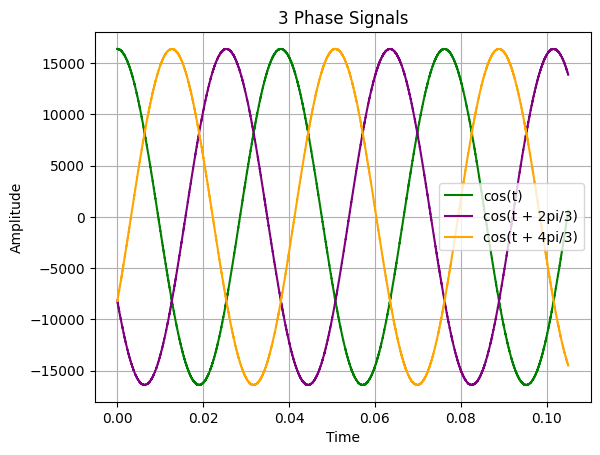

In [21]:
time = np.array(time)*1e-12
plt.plot(time, phaseAx, color = 'green', label='cos(t)')
plt.plot(time, phaseBx, color = 'purple',  label='cos(t + 2pi/3)')
plt.plot(time, phaseCx, color = 'orange', label='cos(t + 4pi/3)')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('3 Phase Signals')
plt.grid(True)
plt.show()


# 4) Perform Analysis (FFT & Differntial Analysis)

Analysis of sigma delta's are interesting. We want to reduce power lost due to high frequency switching due to quantization noise shaping. By changing modulation schemes and by analyzing frequency, and power spectrums we can get a good idea of this. Thankfully, tools like numpy and scipy already have great support for these features. This code gives a function plot_fft, that uses numpys and scipys packages to reveal the frequency spectrum of our raw sigma delta signal. We use hann windowing to reduce errors in FFT transformations

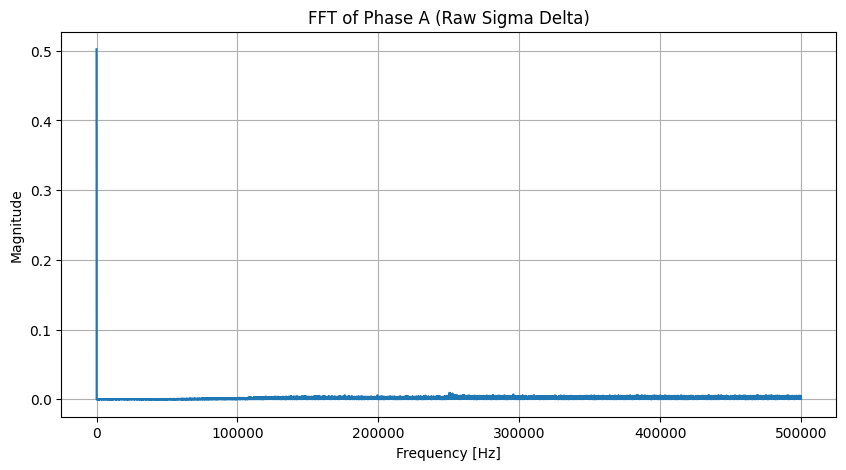

In [22]:
from scipy.fft import fft, fftfreq
import numpy as np
# look below for function usage
def plot_fft(signal, sample_rate, title="FFT Analysis"):
    signal = np.array(signal)
    N = len(signal)

    window = np.hanning(N)
    windowed_signal = signal * window

    fft_vals = fft(windowed_signal)
    fft_mag = np.abs(fft_vals[:N//2]) * 2 / N   # magnitude spectrum
    freqs = fftfreq(N, 1/sample_rate)[:N//2]

    plt.figure(figsize=(10,5))
    plt.plot(freqs, fft_mag)
    plt.title(title)
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Magnitude")
    plt.grid(True)
    plt.show()

sample_rate = 1e6  # 1 MHz clock

plot_fft(phaseA, sample_rate, title="FFT of Phase A (Raw Sigma Delta)") # function usage ^

However its hard to get a good idea of whats going on. Using another of scipy's functions, we can get a good idea of the power spectrum with Welch's method https://en.wikipedia.org/wiki/Welch%27s_method

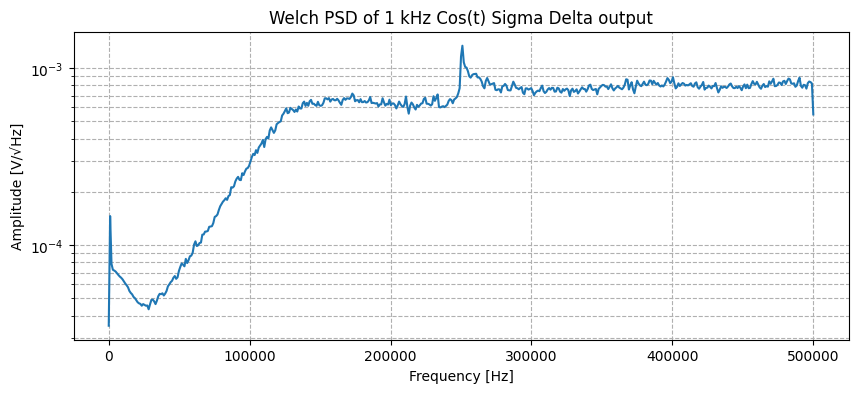

In [23]:
from scipy.signal import welch

def plot_welch_psd(signal, sample_rate, nperseg=1024, title="Welch PSD with Hann Window"):

    f, Pxx = welch(signal, fs=sample_rate, window='hann', nperseg=nperseg, scaling='density')

    plt.figure(figsize=(10, 4))
    plt.semilogy(f, np.sqrt(Pxx))  # sqrt(Pxx) -> amplitude spectral density
    plt.title(title)
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Amplitude [V/√Hz]")
    plt.grid(True, which="both", ls="--")
    plt.show()

# Example usage (1 kHz sine at 1 MHz sample rate)
Fs = 1e6
t = np.arange(0, 0.01, 1/Fs)

plot_welch_psd(np.array(phaseA), Fs, nperseg=1024, title="Welch PSD of 1 kHz Cos(t) Sigma Delta output")


Now it's clear to see our signal's power compared to the noise. Comparing all three modulations schemes we can see that there are issues with each, but there is still a lot of work to be done. So, we hope to improve these.

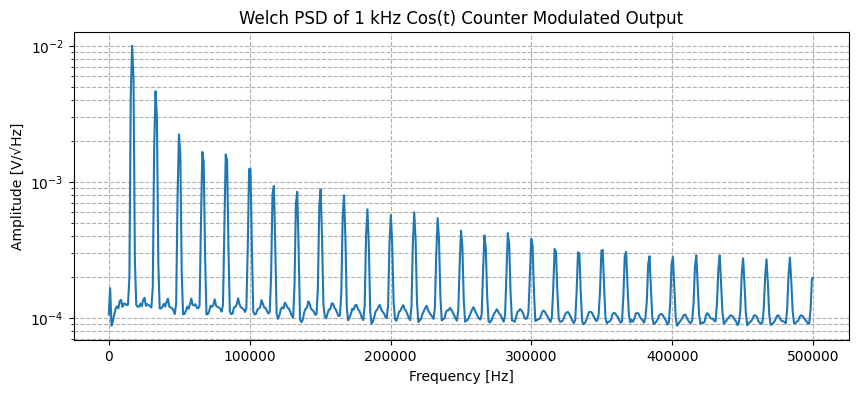

In [24]:
plot_welch_psd(np.array(countA), Fs, nperseg=1024, title="Welch PSD of 1 kHz Cos(t) Counter Modulated Output")

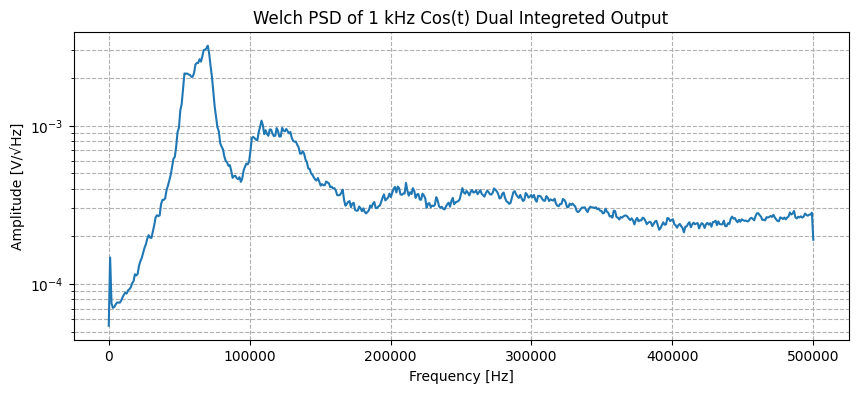

In [25]:
plot_welch_psd(np.array(pwmA), Fs, nperseg=1024, title="Welch PSD of 1 kHz Cos(t) Dual Integreted Output")

Currently, a dual integrating design reduces the most high frequency noise, but there are still issues in nearer low frequencies.

To get a clearer idea of whats happening lets understand the outputs behavior against an actual circuit. 

Initially I tried this circuit. 

![image.png](scc.png)

However it does not capture a real circuit (capacitors have to have a load)

![Circuit with corrections](circuit.png)

To solve these circuits the game is simple. We use a Forward Euler piecewise differential equation solver. The modulation scheme from the raw sigma delta follows a switching reduction pattern where two ones are positive, a one and zero are 0 and two zeros are negative. 

These are our equations!

L di_RL/dt = v - R*i_RL

i_C = C * dv/dt

i_s = i_RL + i_C


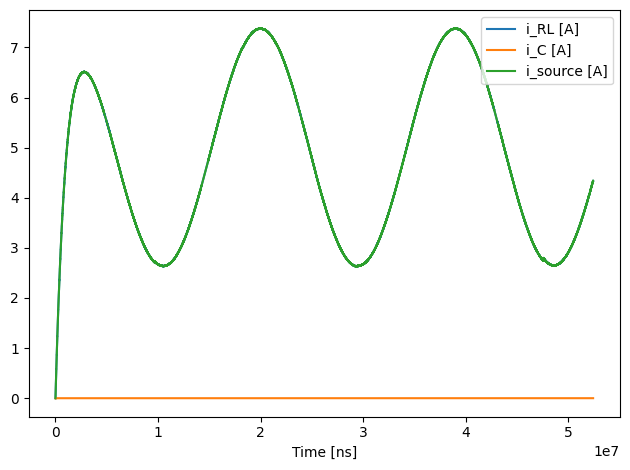

In [26]:
R = 1.0      
L = 1e-3     
C = 20e-12   

T_sample = 500e-9               
v_input_coarse = np.array(phaseA)  
v_input_coarse = 10.0 * v_input_coarse  

upsample_factor = 2
dt = T_sample / upsample_factor   # 2.5 ns step for the solver

N_coarse = len(v_input_coarse)
t_coarse = np.arange(N_coarse) * T_sample
# We go up to the last coarse time and include endpoint using linspace for exact alignment
t_fine = np.linspace(t_coarse[0], t_coarse[-1], (N_coarse - 1)*upsample_factor + 1)

# Linearly interpolated input at fine time steps
v_input = np.interp(t_fine, t_coarse, v_input_coarse)

N = len(t_fine)
i_RL = np.zeros(N)   # current through the series R-L branch
i_C  = np.zeros(N)   # capacitor current
i_s  = np.zeros(N)   # source current (i_RL + i_C)

for n in range(1, N):

    di = (v_input[n-1] - R * i_RL[n-1]) * (dt / L)
    i_RL[n] = i_RL[n-1] + di

    dv = (v_input[n] - v_input[n-1]) / dt   

    i_C[n] = C * dv

    i_s[n] = i_RL[n] + i_C[n]


plt.figure()
plt.plot(t_fine*1e9, i_RL, label="i_RL [A]")
plt.plot(t_fine*1e9, i_C,  label="i_C [A]")
plt.plot(t_fine*1e9, i_s,  label="i_source [A]")
plt.xlabel("Time [ns]")
plt.legend()
plt.tight_layout()
plt.show()


Looks wonky... right? That was a capacitor with no resistance (not real). Now lets take a look at a capcitor with resistance, circuit two.

Resistor input current:

i_in = vin - vnode / Rin

ic = c dv/dt

vc = vnode - vRL

L di/dt = vnode - RL * iL	​


C:\Users\herna\AppData\Local\Temp\ipykernel_42804\1378330745.py:39: RuntimeWarning: overflow encountered in scalar divide
  vC[n] = vc_prev + dt * (iC[n] / C)
C:\Users\herna\AppData\Local\Temp\ipykernel_42804\1378330745.py:36: RuntimeWarning: invalid value encountered in scalar subtract
  iC[n] = (vnode[n] - vc_prev) / R_L


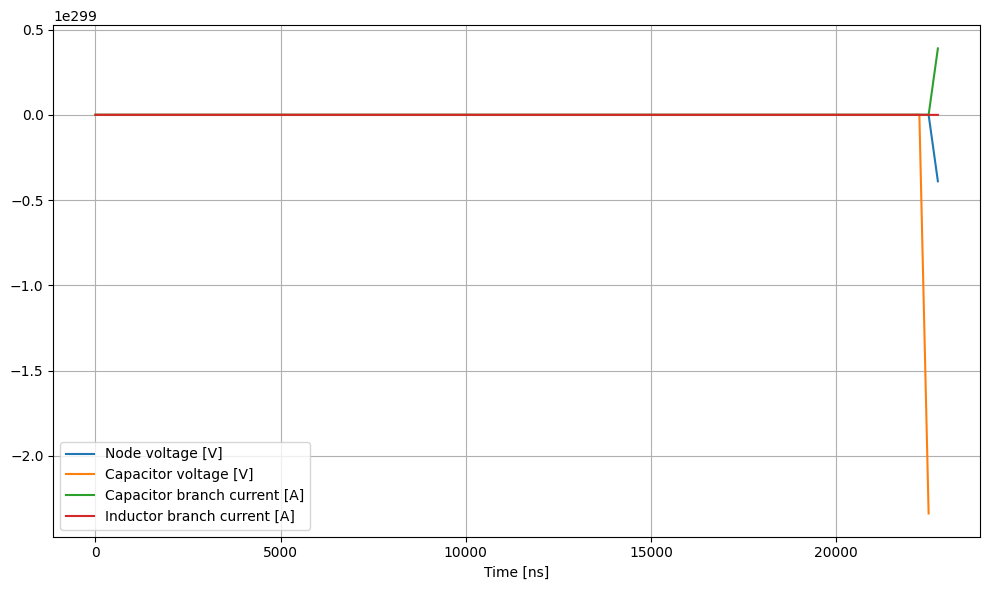

In [27]:
# Parameters
R_in   = 1.0        # input series resistance
R_L    = 5.0       # load resistance after capacitor
R_rl  = 1e6        # very large resistance on inductor branch
L      = 1e-3       # Henries
C      = 20e-12     # Farads

T_sample = 500e-9
v_input_coarse = np.array(phaseA)  # ask question about modulation
v_input_coarse = 10.0 * v_input_coarse      # scale to 10 V

upsample_factor = 2
dt = T_sample / upsample_factor   

N_coarse = len(v_input_coarse)
t_coarse = np.arange(N_coarse) * T_sample # populate time 
t_fine = np.linspace(t_coarse[0], t_coarse[-1], (N_coarse - 1)*upsample_factor + 1)
v_input = np.interp(t_fine, t_coarse, v_input_coarse) # interpolate values

# values
N = len(t_fine)
vC   = np.zeros(N)   # capacitor voltage
iL   = np.zeros(N)   # inductor current
vnode = np.zeros(N)  # node voltage
i_in = np.zeros(N)   # input current
iC   = np.zeros(N)   # capacitor branch current

for n in range(1, N):
    vc_prev = vC[n-1]
    iL_prev = iL[n-1]
    vin     = v_input[n]
    vnode_estimate = ( (vin/R_in) + (vc_prev/R_L) + iL_prev ) / ( (1/R_in) + (1/R_L) )
    vnode[n] = vnode_estimate

    # Capacitor branch current
    iC[n] = (vnode[n] - vc_prev) / R_L

    # Update capacitor voltage using Euler: C *dvC/dt = iC
    vC[n] = vc_prev + dt * (iC[n] / C)

    # Update inductor current: L di/dt = vnode - R*iL
    diL = (vnode[n] - R_rl*iL_prev) * (1/ L)
    iL[n] = iL_prev + diL*dt

    # Input current
    i_in[n] = (vin - vnode[n]) / R_in

# Plot
plt.figure(figsize=(10,6))
plt.plot(t_fine*1e9, vnode, label="Node voltage [V]")
plt.plot(t_fine*1e9, vC, label="Capacitor voltage [V]")
plt.plot(t_fine*1e9, iC, label="Capacitor branch current [A]")
plt.plot(t_fine*1e9, iL, label="Inductor branch current [A]")
plt.xlabel("Time [ns]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
